In [14]:
# Set up
%pylab
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tqdm
import random
import pandas as pd
from collections import Counter
from itertools import cycle

from sklearn import datasets, metrics, tree
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import spectral
import seaborn as sns 
import tqdm

import DecisionTree
import graphviz

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Zadanie 2. (1 punkt)
W pakiecie SciKit do Pythona dostępnych jest kilka popularnych algorytmów klasyfikacji danych <br/>
przy użyciu drzew klasyfikacyjnych. Zapoznaj się z nimi wykonując skrypt umieszczony w<br/>
materiałach do wykładu. Do rysowania drzew użyj programu Graphviz.<br/>
<br/>
a) Jaką miarę różnorodności stosuje algorytm konstrukcji drzew klasyfikujących użyty w skrypcie?<br/>
Dla danych Titanic sporządź drzewa klasyfikacyjne stosując indeks Giniego oraz entropię.<br/>
<br/>
b) Podziel dane Titanic na dane uczące i dane testowe (jak w zadaniu 1b), stwórz drzewa<br/>
klasyfikacyjne na danych uczących i przetestuj na danych testowych.<br/>
<br/>
c) Spróbuj ograniczyć głębokość drzewa. Zobacz jak wpływa to na wyniki (zarówno na danych<br/>
uczących jak i na danych testowych).<br/>
<br/>
d) Spróbuj przyciąć drzewo techniką omawianą na wykładzie lub własną. Zobacz jak wpływa to na<br/>
wyniki (zarówno na danych uczących jak i na danych testowych).<br/>
<br/>
e) Zrób cross validation wszystkich tworzonych w tym zadaniu klasyfikatorów na zestawie danych<br/>
Titanic. <br/>



# a) b)


In [2]:
titanic_train = pd.read_csv('data/train.csv')
titanic_test = pd.read_csv('data/test.csv')

X = titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
X = X.dropna()
X['Sex'] = pd.Categorical(X['Sex']).codes
X['Embarked'] = pd.Categorical(X['Embarked']).codes

X.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [25]:
def cross_validation(X, no=10, criterion='gini', max_depth=1000, min_samples_split=None, min_samples_leaf=None):
    err_sum = 0
    Y = X['Survived']
    X = X.drop('Survived', axis=1)
    indices = np.random.uniform(0, no, len(X)).astype(int)
    print('--------------------------------------')
    print(f'Cross validation using {criterion}')
    for i in range(no):
        x_train = X[indices != i]
        y_train = Y[indices != i]
        x_test = X[indices == i]
        y_test = Y[indices == i]
        
        if min_samples_split and min_samples_leaf:
            model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        else:
            model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
            
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        
        result = list(predictions == y_test)
        result_cnt = result.count(True) / len(result) * 100
          
        err_sum += result_cnt
        print(f'Test: {i} -> score: {result_cnt}\n')
        
    print(f'Final error: {err_sum / no}\n')
        
        
def build_Tree(X_train, X_test, criterion='gini', max_depth=1000, min_samples_split=None, min_samples_leaf=None):
    Y_train = X_train['Survived']
    X_train = X_train.drop('Survived', axis=1)
    Y_test = X_test['Survived']
    X_test = X_test.drop('Survived', axis=1)

    model = None
    name = 'titanic.dot'
    if min_samples_split and min_samples_leaf:
        model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        name = 'prunned_' + name
    else:
        model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
        
    model.fit(X_train, Y_train)
    print(f'Classification using {criterion}')
    print(metrics.confusion_matrix(model.predict(X_test), Y_test))
    print(f'Score: {model.score(X_test, Y_test) * 100:.2f}%\n')
    
    return model, X_train

def draw_tree(tree_,feature_names, target_names, name):
    dot_data = tree.export_graphviz(tree_, out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render(name) 
    dot_data = tree.export_graphviz(tree_, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph 

In [26]:
X_train, X_test = train_test_split(X, test_size=0.3333)
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini')
entropy_tree, entropy_X  = build_Tree(X_train, X_test, criterion='entropy')

cross_validation(X, criterion='entropy')
cross_validation(X, criterion='gini')

Classification using gini
[[109  28]
 [ 30  71]]
Score: 75.63%

Classification using entropy
[[111  28]
 [ 28  71]]
Score: 76.47%

--------------------------------------
Cross validation using entropy
Test: 0 -> score: 79.41176470588235

Test: 1 -> score: 68.83116883116884

Test: 2 -> score: 78.2051282051282

Test: 3 -> score: 85.36585365853658

Test: 4 -> score: 83.60655737704919

Test: 5 -> score: 72.3076923076923

Test: 6 -> score: 74.35897435897436

Test: 7 -> score: 67.74193548387096

Test: 8 -> score: 75.75757575757575

Test: 9 -> score: 76.0

Final error: 76.15866506858785

--------------------------------------
Cross validation using gini
Test: 0 -> score: 71.05263157894737

Test: 1 -> score: 73.01587301587301

Test: 2 -> score: 84.375

Test: 3 -> score: 79.45205479452055

Test: 4 -> score: 85.33333333333334

Test: 5 -> score: 75.90361445783132

Test: 6 -> score: 74.28571428571429

Test: 7 -> score: 75.0

Test: 8 -> score: 73.91304347826086

Test: 9 -> score: 76.0

Final error:

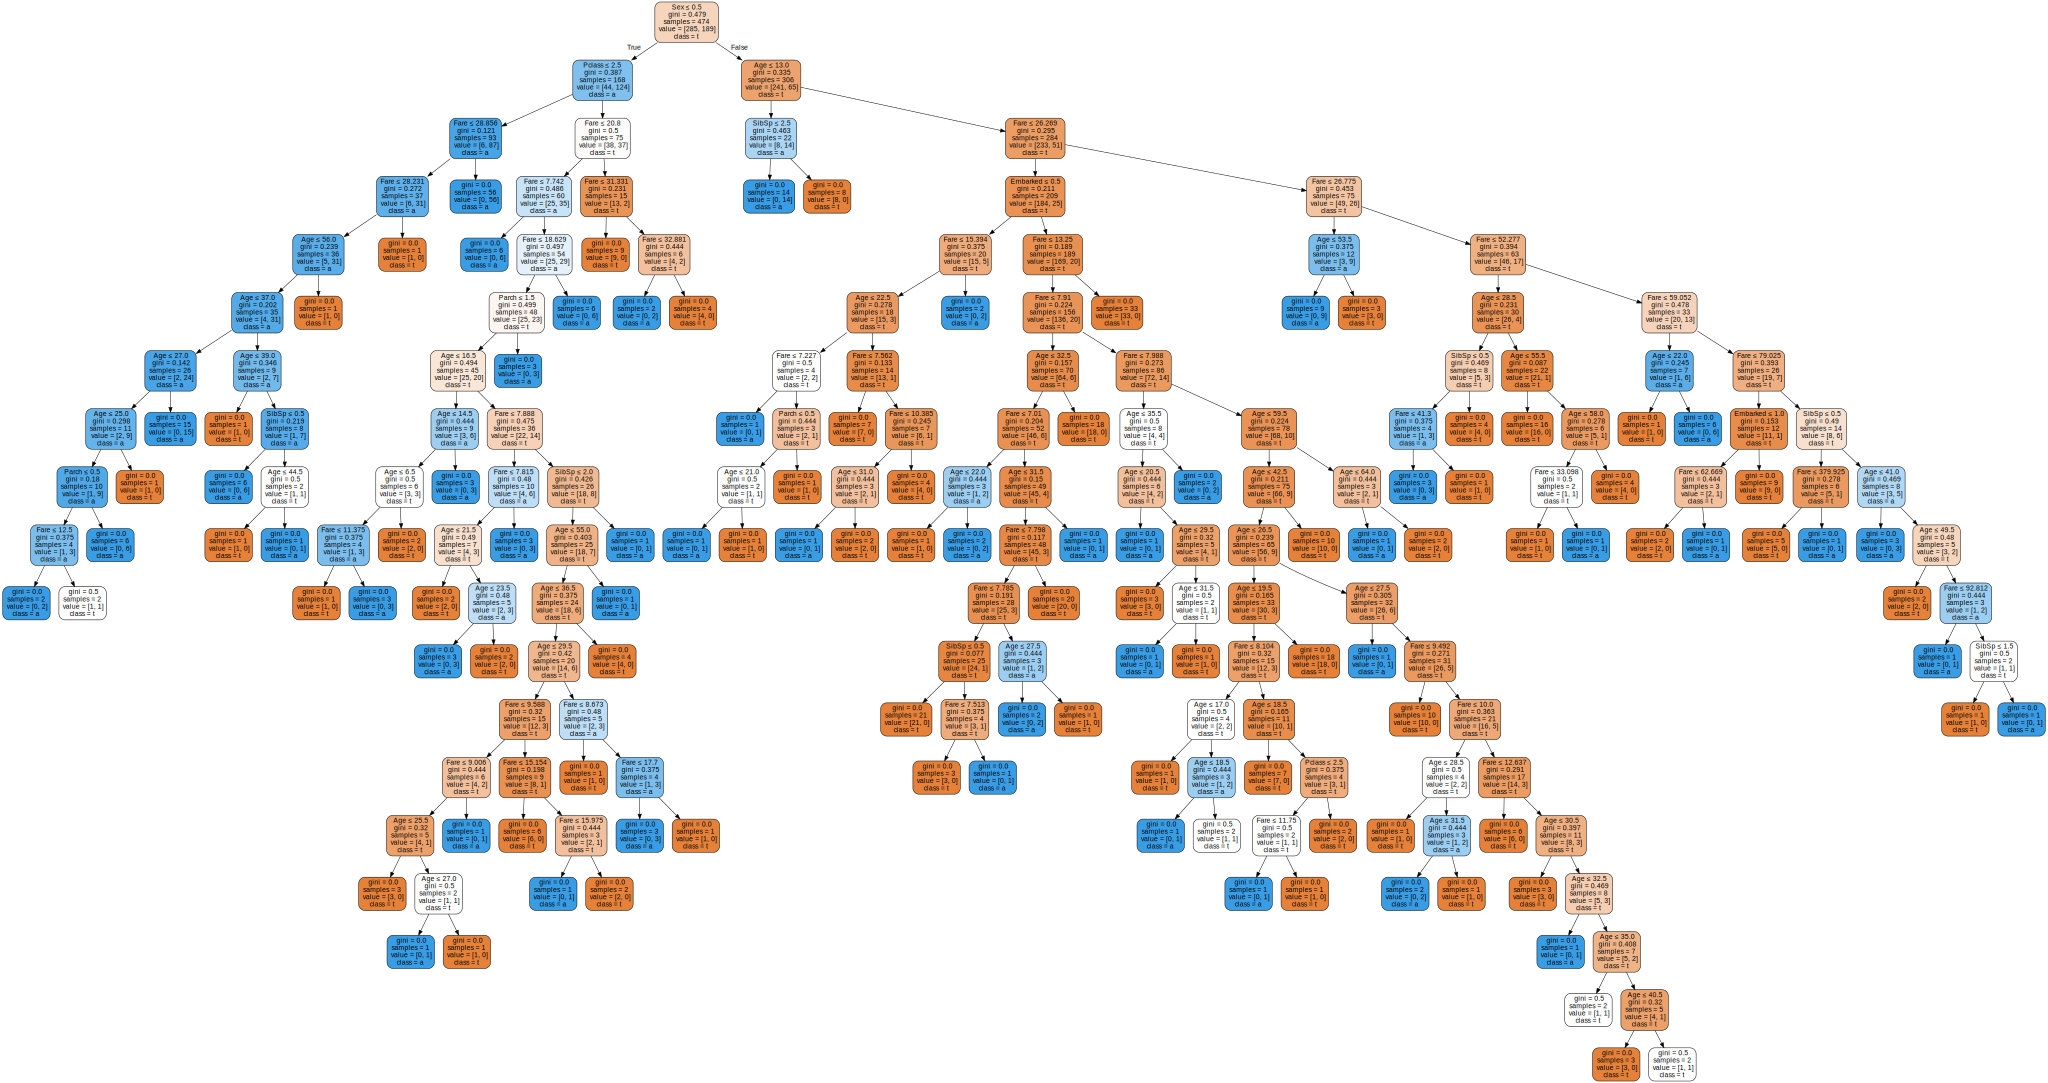

In [27]:
draw_tree(gini_tree, gini_X.columns, 'target', 'titanic_gini')

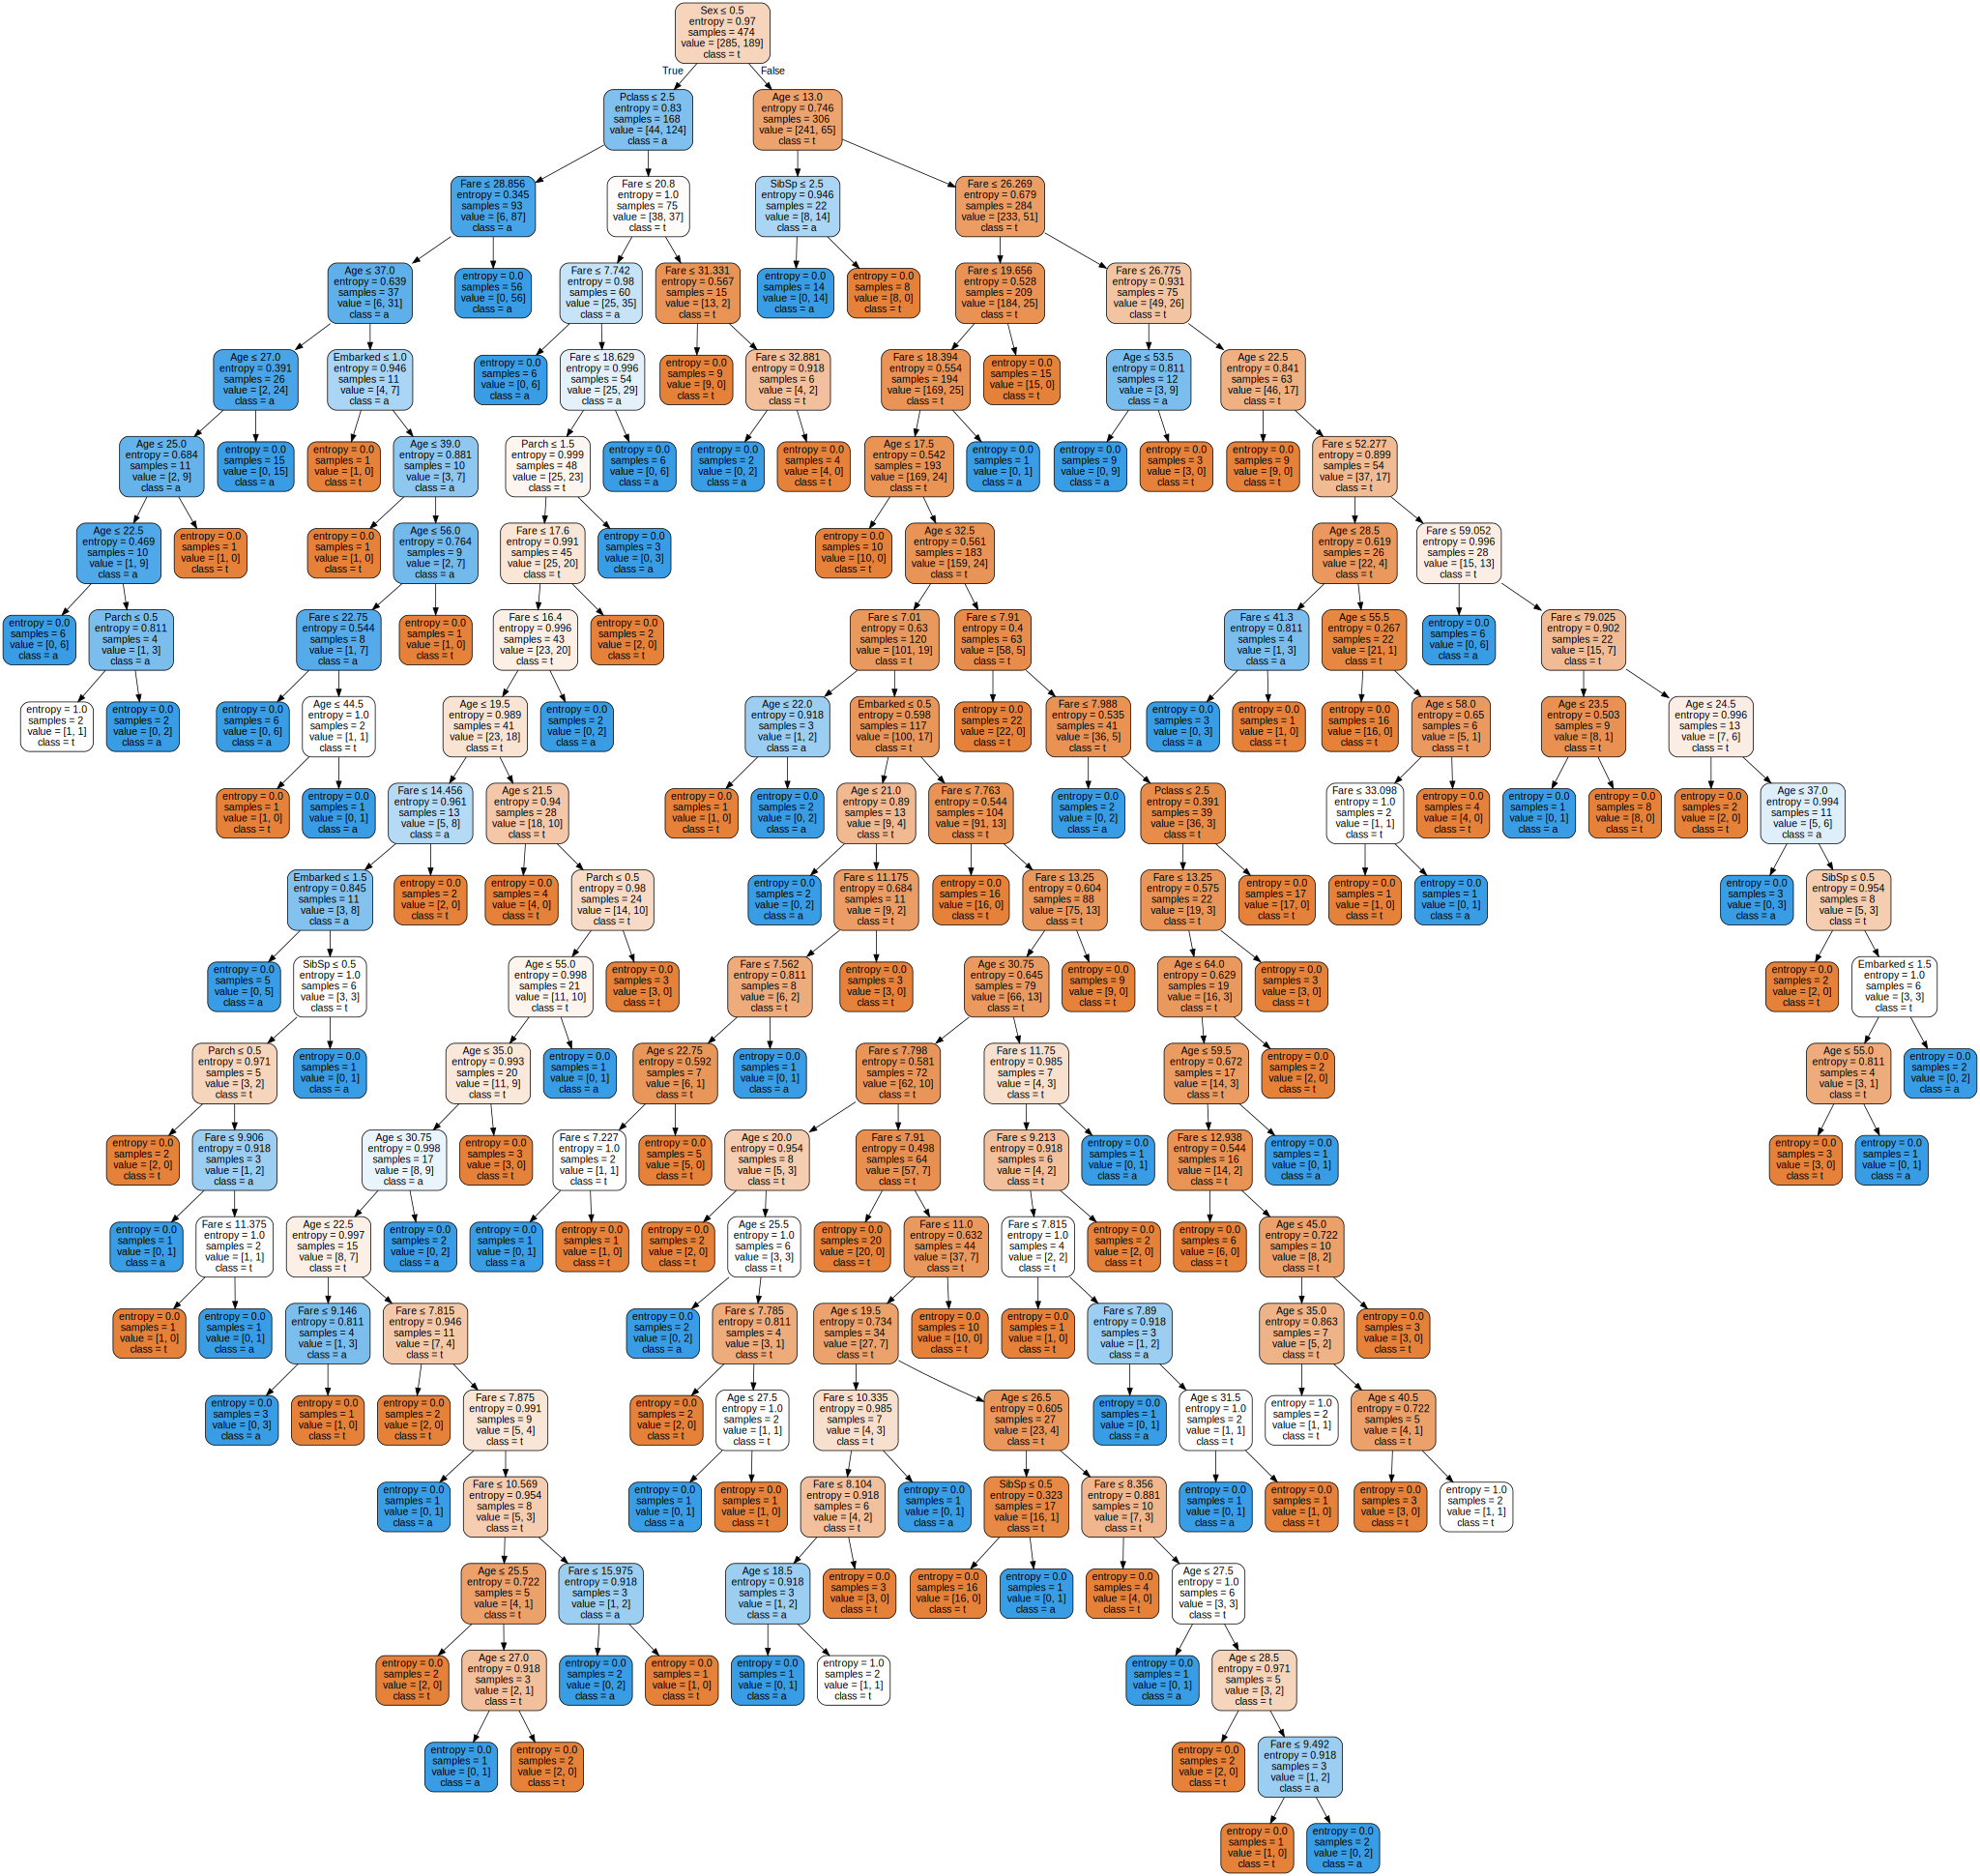

In [28]:
draw_tree(entropy_tree, entropy_X.columns, 'target', 'titanic_entropy')

# c)

In [29]:
# max depth limit
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini', max_depth=5)
entropy_tree, entropy_X = build_Tree(X_train, X_test, criterion='entropy', max_depth=5)

cross_validation(X, criterion='entropy', max_depth=5)
cross_validation(X, criterion='gini', max_depth=5)

Classification using gini
[[131  31]
 [  8  68]]
Score: 83.61%

Classification using entropy
[[132  31]
 [  7  68]]
Score: 84.03%

--------------------------------------
Cross validation using entropy
Test: 0 -> score: 78.78787878787878

Test: 1 -> score: 72.15189873417721

Test: 2 -> score: 79.22077922077922

Test: 3 -> score: 85.91549295774648

Test: 4 -> score: 70.83333333333334

Test: 5 -> score: 84.7457627118644

Test: 6 -> score: 81.53846153846153

Test: 7 -> score: 81.25

Test: 8 -> score: 85.18518518518519

Test: 9 -> score: 78.57142857142857

Final error: 79.82002210408547

--------------------------------------
Cross validation using gini
Test: 0 -> score: 90.0

Test: 1 -> score: 82.08955223880598

Test: 2 -> score: 81.0126582278481

Test: 3 -> score: 85.71428571428571

Test: 4 -> score: 71.01449275362319

Test: 5 -> score: 80.26315789473685

Test: 6 -> score: 77.64705882352942

Test: 7 -> score: 71.7948717948718

Test: 8 -> score: 79.6875

Test: 9 -> score: 75.0

Final error

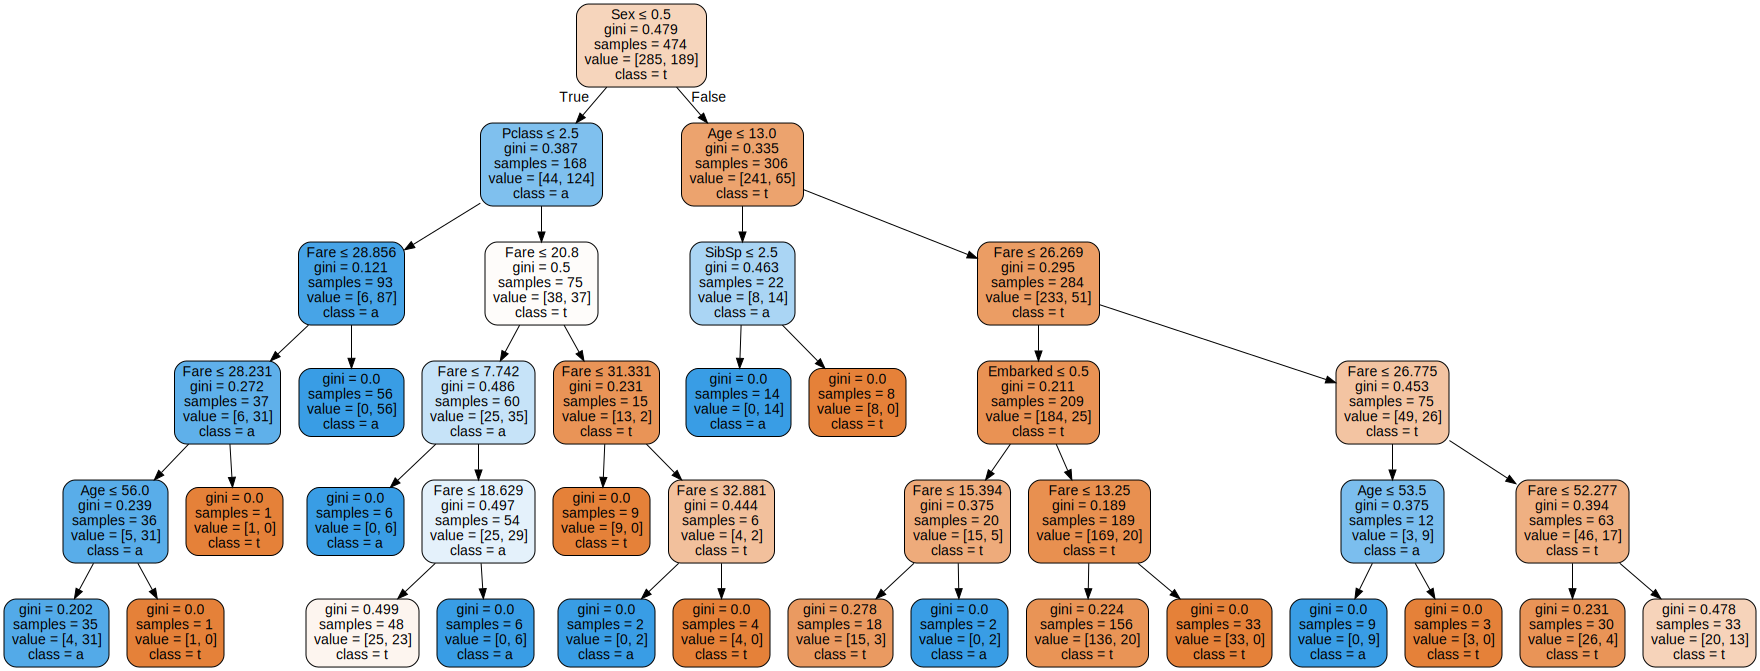

In [30]:
draw_tree(gini_tree, gini_X.columns, 'target', 'titanic_gini_depth')

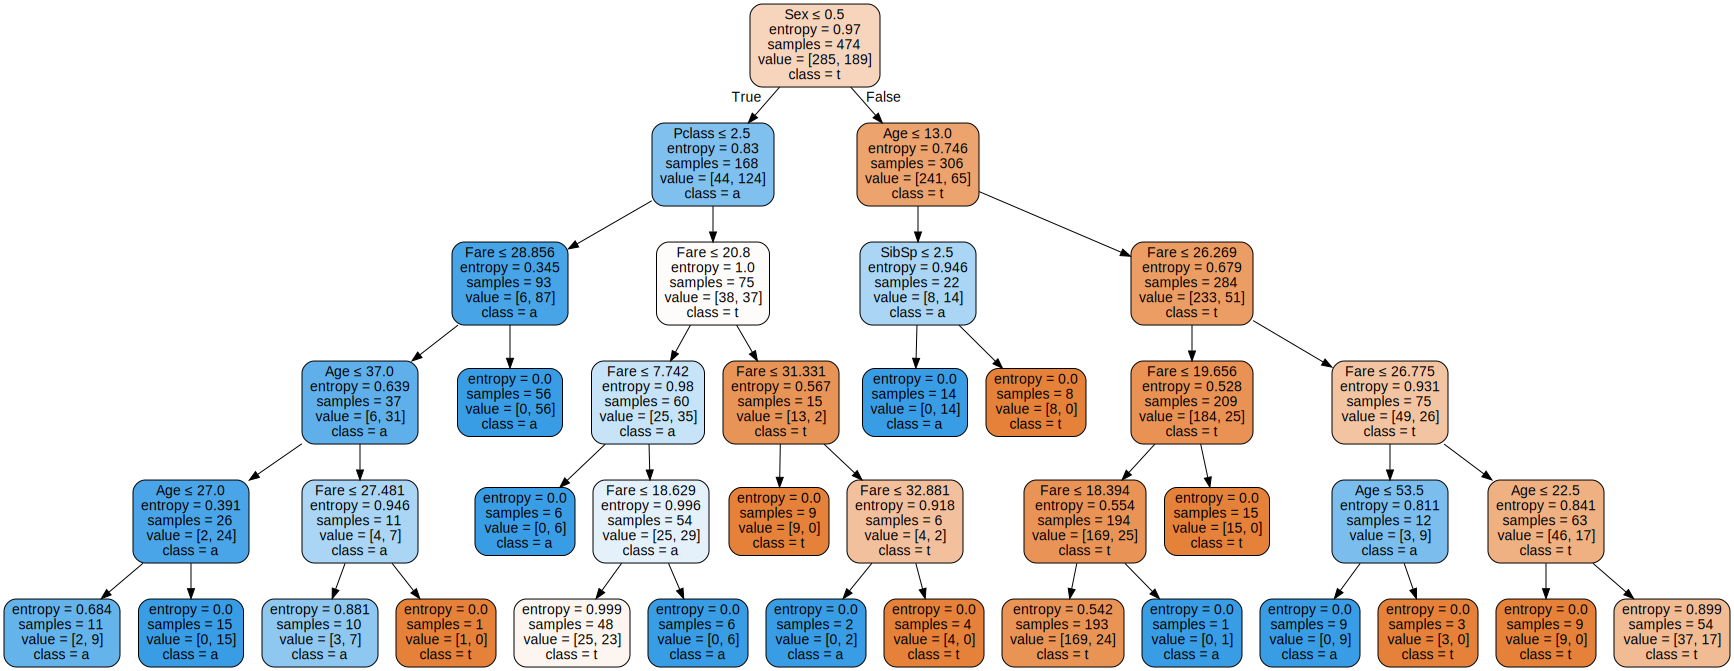

In [31]:
draw_tree(entropy_tree, entropy_X.columns, 'target', 'titanic_entropy_depth')

# d)

In [37]:
# prunning
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=10)
entropy_tree, entropy_X = build_Tree(X_train, X_test, criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=10)

cross_validation(X, criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=5)
cross_validation(X, criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=5)

Classification using gini
[[127  28]
 [ 12  71]]
Score: 83.19%

Classification using entropy
[[127  28]
 [ 12  71]]
Score: 83.19%

--------------------------------------
Cross validation using entropy
Test: 0 -> score: 80.35714285714286

Test: 1 -> score: 75.80645161290323

Test: 2 -> score: 87.87878787878788

Test: 3 -> score: 84.0

Test: 4 -> score: 77.46478873239437

Test: 5 -> score: 80.0

Test: 6 -> score: 84.0909090909091

Test: 7 -> score: 73.07692307692307

Test: 8 -> score: 78.87323943661971

Test: 9 -> score: 77.33333333333333

Final error: 79.88815760190136

--------------------------------------
Cross validation using gini
Test: 0 -> score: 80.76923076923077

Test: 1 -> score: 79.1044776119403

Test: 2 -> score: 84.81012658227847

Test: 3 -> score: 73.23943661971832

Test: 4 -> score: 79.72972972972973

Test: 5 -> score: 80.0

Test: 6 -> score: 86.36363636363636

Test: 7 -> score: 69.73684210526315

Test: 8 -> score: 80.0

Test: 9 -> score: 83.33333333333334

Final error: 7

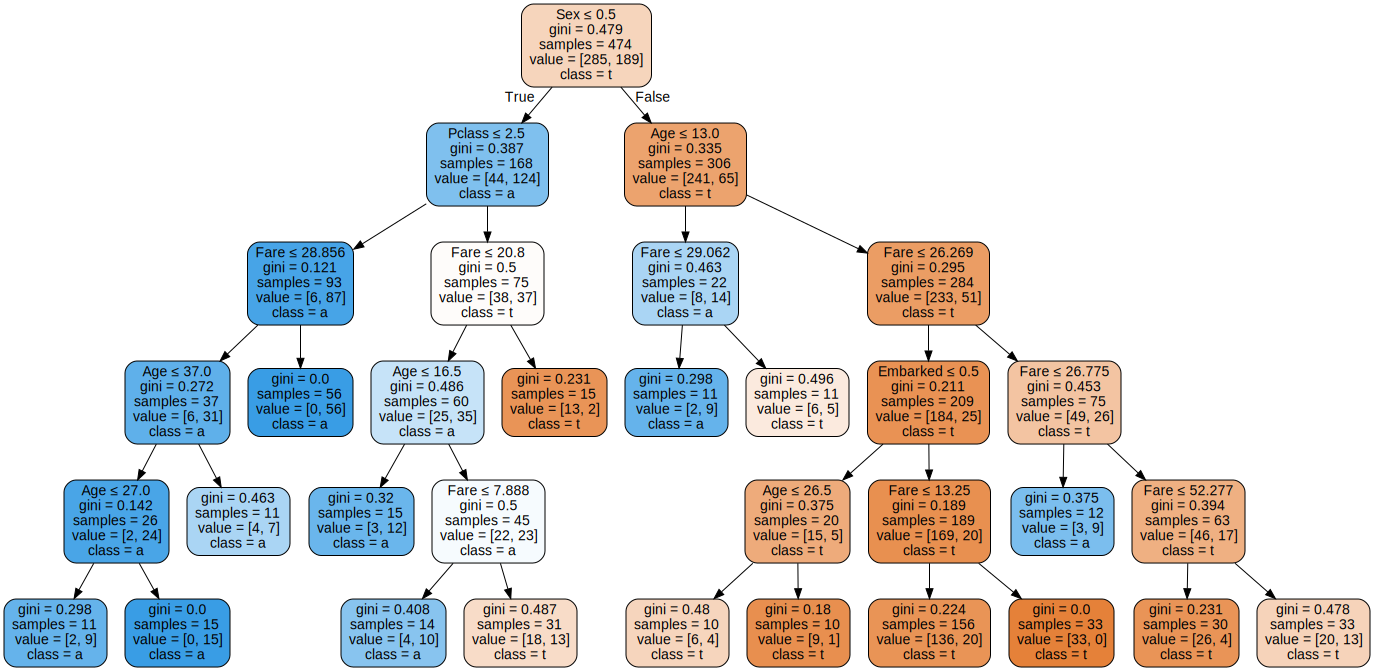

In [38]:
draw_tree(gini_tree, gini_X.columns, 'target', 'titanic_gini_prunned')

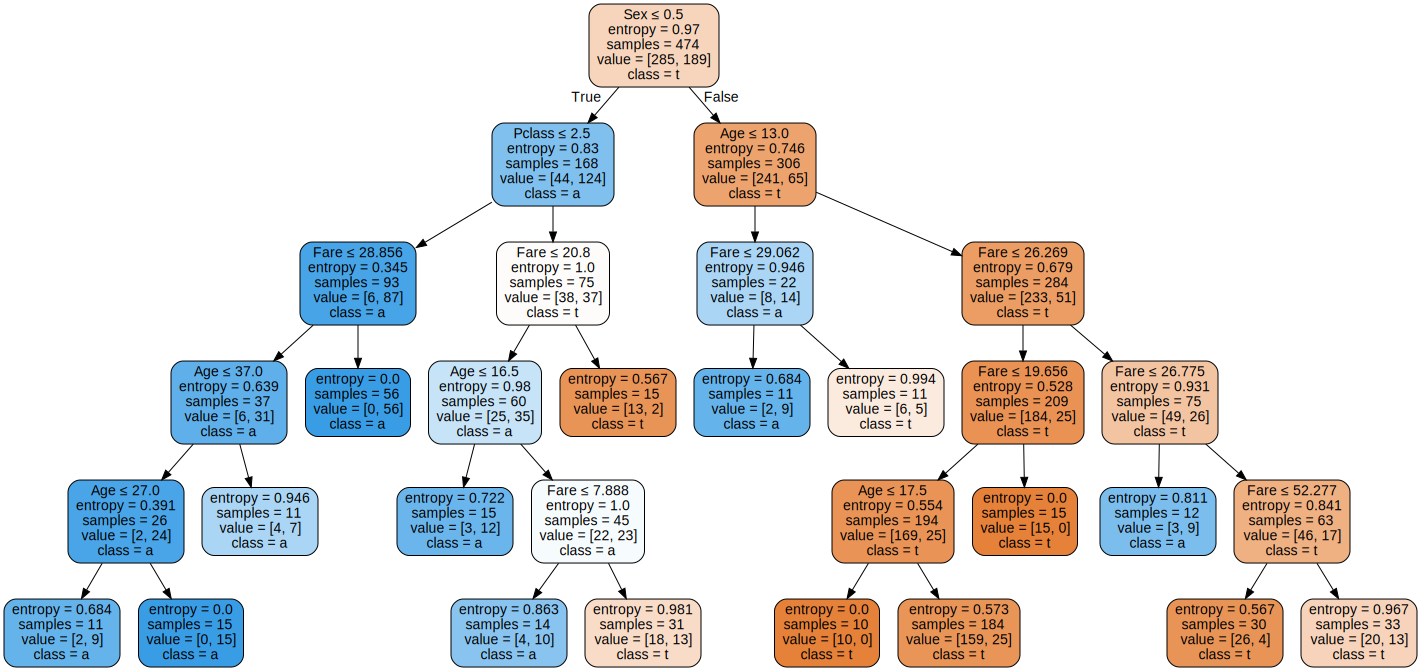

In [39]:
draw_tree(entropy_tree, entropy_X.columns, 'target', 'titanic_entropy_prunned')

# Zadanie 3
**Random Forest i Extremely Randomized Trees**

In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [200]:
# TITANIC
X_titanic_train, X_titanic_test = train_test_split(X, test_size=0.3333)
Y_titanic_train = X_titanic_train['Survived']
X_titanic_train = X_titanic_train.drop('Survived', axis=1)

Y_titanic_test = X_titanic_test['Survived']
X_titanic_test = X_titanic_test.drop('Survived', axis=1)

In [201]:
random_forest = RandomForestClassifier(n_estimators=20)
extra_random_forest = ExtraTreesClassifier(n_estimators=20)

random_forest.fit(X_titanic_train, Y_titanic_train)
extra_random_forest.fit(X_titanic_train, Y_titanic_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [202]:
print('Random Forest:')
print(metrics.confusion_matrix(random_forest.predict(X_titanic_test), Y_titanic_test))
print(f'Score: {random_forest.score(X_titanic_test, Y_titanic_test) * 100:.2f}%\n')

Random Forest:
[[119  30]
 [ 23  66]]
Score: 77.73%



In [203]:
print('Extremely Randomized Trees:')
print(metrics.confusion_matrix(extra_random_forest.predict(X_titanic_test), Y_titanic_test))
print(f'Score: {extra_random_forest.score(X_titanic_test, Y_titanic_test) * 100:.2f}%\n')

Extremely Randomized Trees:
[[123  33]
 [ 19  63]]
Score: 78.15%



In [207]:
# Iris
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [209]:
X_iris_train, X_iris_test = train_test_split(iris_df, test_size=0.3333)
Y_iris_train = X_iris_train['species']
X_iris_train = X_iris_train.drop('species', axis=1)

Y_iris_test = X_iris_test['species']
X_iris_test = X_iris_test.drop('species', axis=1)

In [210]:
random_forest = RandomForestClassifier(n_estimators=20)
extra_random_forest = ExtraTreesClassifier(n_estimators=20)

random_forest.fit(X_iris_train, Y_iris_train)
extra_random_forest.fit(X_iris_train, Y_iris_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [213]:
print('Random Forest:')
print(metrics.confusion_matrix(random_forest.predict(X_iris_test), Y_iris_test))
print(f'Score: {random_forest.score(X_iris_test, Y_iris_test) * 100:.2f}%\n')

Random Forest:
[[14  0  0]
 [ 0 19  1]
 [ 0  2 14]]
Score: 94.00%



In [215]:
print('Extremely Randomized Trees:')
print(metrics.confusion_matrix(extra_random_forest.predict(X_iris_test), Y_iris_test))
print(f'Score: {extra_random_forest.score(X_iris_test, Y_iris_test) * 100:.2f}%\n')

Extremely Randomized Trees:
[[14  0  0]
 [ 0 19  0]
 [ 0  2 15]]
Score: 96.00%

